In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [2]:
df = pd.read_csv("/kaggle/input/prepossessed-arrays-of-binary-data/1000_Binary Dataframe")
df.head(n=5)

,Unnamed: 0,exists,eye_side,level,path,patient_id,level_cat
0,0,True,left,0,../input/diabetic-retinopathy-detection/10_lef...,10,[1. 0.]
1,1,True,right,0,../input/diabetic-retinopathy-detection/10_rig...,10,[1. 0.]
2,2,True,left,0,../input/diabetic-retinopathy-detection/13_lef...,13,[1. 0.]
3,3,True,right,0,../input/diabetic-retinopathy-detection/13_rig...,13,[1. 0.]
4,8,True,left,0,../input/diabetic-retinopathy-detection/17_lef...,17,[1. 0.]


In [3]:
df.shape

(1000, 7)

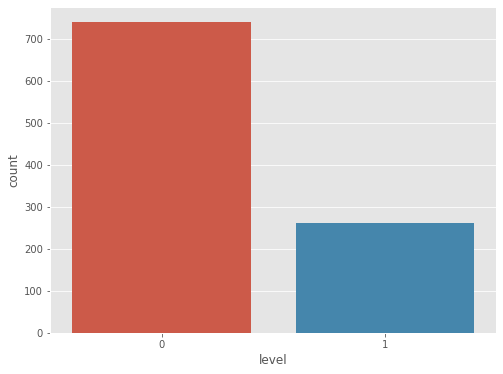

In [4]:
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
sns.countplot(data=df,x = 'level')
plt.show()

In [5]:
images_264 = np.load('../input/prepossessed-arrays-of-binary-data/1000_Binary_images_data_264.npz')
X_264=images_264['a']
y=df['level'].values


print(X_264.shape)
print(y.shape)

(1000, 209088)
(1000,)


In [6]:
print("Shape before reshaping X_264" +str(X_264.shape))
X_264=X_264.reshape(1000,264,264,3)
print("Shape after reshaping X_264" +str(X_264.shape))

Shape before reshaping X_264(1000, 209088)
Shape after reshaping X_264(1000, 264, 264, 3)


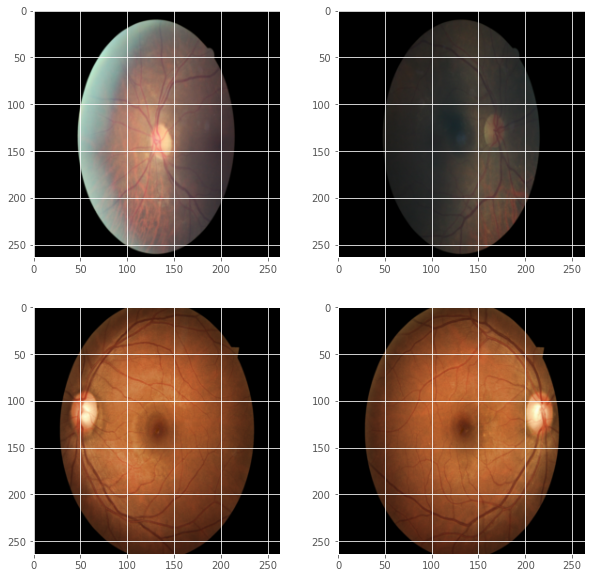

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(X_264[0])
plt.subplot(2,2,2)
plt.imshow(X_264[1])
plt.subplot(2,2,3)
plt.imshow(X_264[2])
plt.subplot(2,2,4)
plt.imshow(X_264[3])
plt.show()

In [8]:
import skimage.segmentation
from matplotlib import pyplot as plt

X_seg = []

for img in X_264:
    res1 = skimage.segmentation.felzenszwalb(img, scale=50)
    X_seg.append(res1)

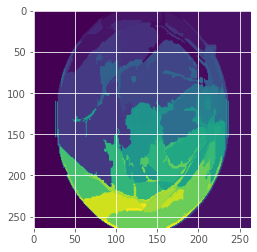

In [9]:
plt.imshow(X_seg[3])
plt.show()

In [10]:
X_seg[0].shape

(264, 264)

In [11]:
X=np.array(X_264)
Y=np.array(y)
Y=to_categorical(Y,2)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1, test_size=0.4, random_state=101)
print(len(x_train),len(x_val),len(x_test))

700 120 180


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
augment = ImageDataGenerator( 
                             rotation_range=20,
                              width_shift_range=0.01, 
                              height_shift_range=0.01, 
                              horizontal_flip=False, 
                              vertical_flip=False,
                            )
augment.fit(x_train)

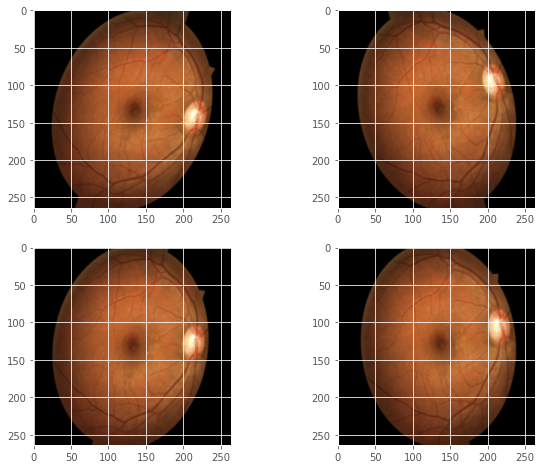

In [14]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,2)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,3)
plt.imshow(augment.random_transform(X_264[3]))
plt.subplot(2,2,4)
plt.imshow(augment.random_transform(X_264[3]))
plt.show()

In [15]:
model = ResNet50(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

94773248/94765736 [==============================] - 2s 0us/step


In [16]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 270, 270, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 132, 132, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 132, 132, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
for ix in range(len(model.layers)):
    print(ix,model.layers[ix])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7930f8cb10>
1 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f7830a3bb90>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f78301d9b50>
3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7830197fd0>
4 <tensorflow.python.keras.layers.core.Activation object at 0x7f783014afd0>
5 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f78301115d0>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7830114310>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7830120810>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7830126290>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f7830129110>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7830135e90>
11 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization o

In [18]:
for layer in model.layers[:169]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [19]:
av1 = Flatten()(model.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_resnet = Model(model.input,fc3)
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 270, 270, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 132, 132, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 132, 132, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
adam = Adam(learning_rate=0.0001)
model_resnet.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [21]:
filepath="retina_resnet50.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [22]:
hist2 = model_resnet.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 40,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/40
22/22 [==============================] - 14s 209ms/step - loss: 7.2707 - accuracy: 0.6536 - val_loss: 3.9890 - val_accuracy: 0.7417

Epoch 00001: val_loss improved from inf to 3.98898, saving model to retina_resnet50.hdf5
Epoch 2/40
22/22 [==============================] - 2s 114ms/step - loss: 3.7311 - accuracy: 0.6454 - val_loss: 2.8685 - val_accuracy: 0.7417

Epoch 00002: val_loss improved from 3.98898 to 2.86852, saving model to retina_resnet50.hdf5
Epoch 3/40
22/22 [==============================] - 2s 110ms/step - loss: 2.8167 - accuracy: 0.6869 - val_loss: 2.5635 - val_accuracy: 0.7417

Epoch 00003: val_loss improved from 2.86852 to 2.56352, saving model to retina_resnet50.hdf5
Epoch 4/40
22/22 [==============================] - 2s 109ms/step - loss: 2.5756 - accuracy: 0.7142 - val_loss: 2.4480 - val_accuracy: 0.7417

Epoch 00004: val_loss improved from 2.56352 to 2.44804, saving model to retina_resnet50.hdf5
Epoch 5/40
22/22 [==============================] - 2s 110m

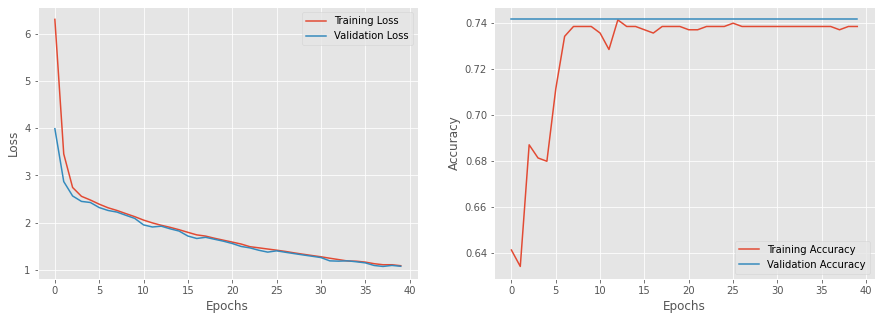

In [23]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist2.history["loss"], label = "Training Loss")
plt.plot( hist2.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist2.history["accuracy"], label = "Training Accuracy")
plt.plot( hist2.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [24]:
model_resnet.evaluate(x_test,y_test)

6/6 [==============================] - 1s 138ms/step - loss: 1.0748 - accuracy: 0.7389


[1.0747945308685303, 0.7388888597488403]

In [25]:
predictions = model_resnet.predict(x_test, batch_size = 32)
pred2 = np.argmax(predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)

In [26]:
print(classification_report(y_test2, pred2))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85       133
           1       0.00      0.00      0.00        47

    accuracy                           0.74       180
   macro avg       0.37      0.50      0.42       180
weighted avg       0.55      0.74      0.63       180



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(confusion_matrix(y_test2, pred2))

[[133   0]
 [ 47   0]]


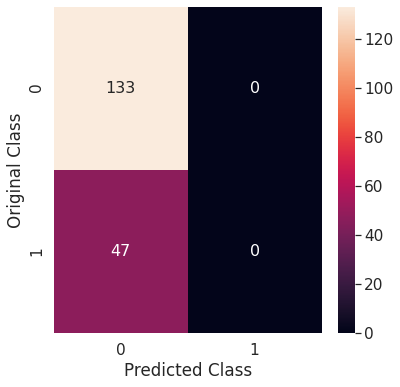

In [28]:
plt.figure(figsize=(6,6))
df_cm2 = pd.DataFrame(confusion_matrix(y_test2, pred2), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm2, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [29]:
y_pred_keras2 = model_resnet.predict(x_test).ravel()

In [30]:
from sklearn.metrics import roc_curve

fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test2, pred2)

In [31]:
from sklearn.metrics import auc
auc_keras2 = auc(fpr_keras2, tpr_keras2)

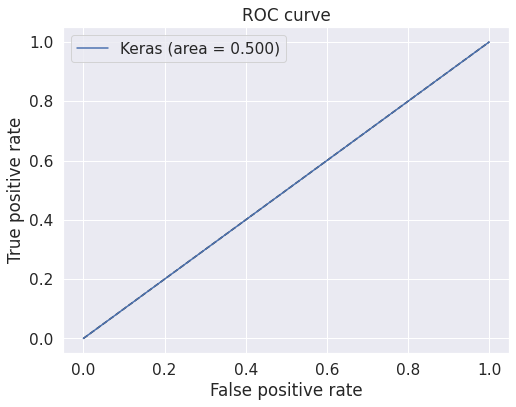

In [32]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras2, tpr_keras2, label='Keras (area = {:.3f})'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [33]:
model1 = InceptionV3(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

87916544/87910968 [==============================] - 0s 0us/step


In [34]:
model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 131, 131, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 131, 131, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 131, 131, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [35]:
for ix in range(len(model1.layers)):
    print(ix,model1.layers[ix])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f779c69a890>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c69a610>
2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f779c6a8910>
3 <tensorflow.python.keras.layers.core.Activation object at 0x7f779c66ff90>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c6b1ad0>
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f779c6d6d10>
6 <tensorflow.python.keras.layers.core.Activation object at 0x7f779c630390>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c63a210>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f779c5c4c90>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f779c5cca90>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f779c5d0690>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c6f

In [36]:
for layer in model1.layers[:299]:
    layer.trainable = False
for i, layer in enumerate(model1.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [37]:
av1 = Flatten()(model1.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)


model_incep = Model(model1.input,fc3)
model_incep.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 264, 264, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 131, 131, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 131, 131, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 131, 131, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [38]:
adam = Adam(learning_rate=0.0001)
model_incep.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [39]:
filepath="retina_incep.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [40]:
hist3 = model_incep.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 40,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/40
22/22 [==============================] - 9s 183ms/step - loss: 7.7346 - accuracy: 0.5886 - val_loss: 6.4649 - val_accuracy: 0.7417

Epoch 00001: val_loss improved from inf to 6.46486, saving model to retina_incep.hdf5
Epoch 2/40
22/22 [==============================] - 2s 84ms/step - loss: 6.4349 - accuracy: 0.6540 - val_loss: 5.7229 - val_accuracy: 0.7250

Epoch 00002: val_loss improved from 6.46486 to 5.72287, saving model to retina_incep.hdf5
Epoch 3/40
22/22 [==============================] - 2s 81ms/step - loss: 5.5988 - accuracy: 0.6923 - val_loss: 5.1348 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 5.72287 to 5.13476, saving model to retina_incep.hdf5
Epoch 4/40
22/22 [==============================] - 2s 80ms/step - loss: 5.0407 - accuracy: 0.7373 - val_loss: 4.6835 - val_accuracy: 0.7417

Epoch 00004: val_loss improved from 5.13476 to 4.68349, saving model to retina_incep.hdf5
Epoch 5/40
22/22 [==============================] - 2s 79ms/step - loss: 4.

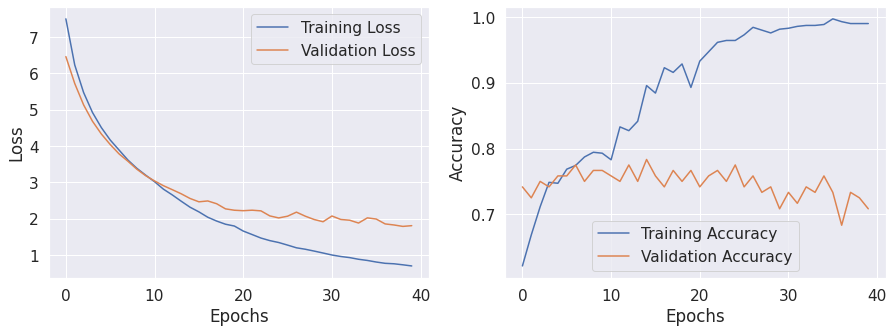

In [41]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist3.history["loss"], label = "Training Loss")
plt.plot( hist3.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist3.history["accuracy"], label = "Training Accuracy")
plt.plot( hist3.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [42]:
model_incep.evaluate(x_test,y_test)

6/6 [==============================] - 1s 128ms/step - loss: 2.0776 - accuracy: 0.7111


[2.0776474475860596, 0.7111111283302307]

In [43]:
predictions3 = model_incep.predict(x_test, batch_size = 32)
pred3 = np.argmax(predictions3, axis=1)
y_test3 = np.argmax(y_test, axis=1)

In [44]:
print(classification_report(y_test3, pred3))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       133
           1       0.43      0.32      0.37        47

    accuracy                           0.71       180
   macro avg       0.60      0.58      0.59       180
weighted avg       0.69      0.71      0.70       180



In [45]:
print(confusion_matrix(y_test3, pred3))

[[113  20]
 [ 32  15]]


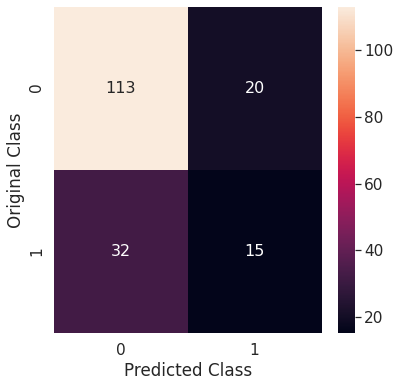

In [46]:
plt.figure(figsize=(6,6))
df_cm3 = pd.DataFrame(confusion_matrix(y_test3, pred3), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm3, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [47]:
y_pred_keras3 = model_incep.predict(x_test).ravel()

In [48]:
from sklearn.metrics import roc_curve

fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test3, pred3)

In [49]:
from sklearn.metrics import auc
auc_keras3 = auc(fpr_keras3, tpr_keras3)

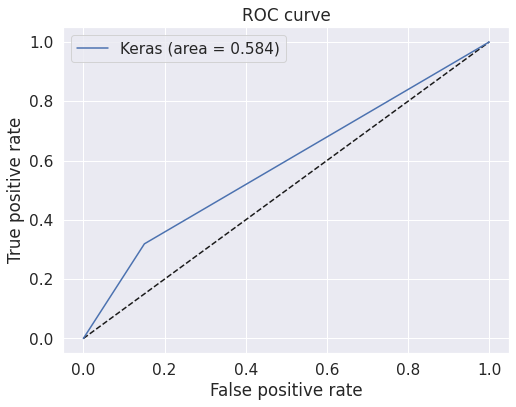

In [50]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [51]:
model2 = VGG16(include_top = False,weights = 'imagenet',input_shape = (264,264,3))

58892288/58889256 [==============================] - 0s 0us/step


In [52]:
model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 264, 264, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 264, 264, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 264, 264, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 132, 132, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 132, 132, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 132, 132, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 66, 66, 128)       0     

In [53]:
for ix in range(len(model2.layers)):
    print(ix,model2.layers[ix])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f77b41e27d0>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c2c7f10>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c118790>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f73be73b3d0>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f73bc30ee10>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c118a50>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f73be734210>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f73bc970d90>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f73bc9705d0>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f779c129210>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f73bc979e10>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f73bc97ebd0>
12 <tensorflow.python.ke

In [54]:
for layer in model2.layers[:16]:
    layer.trainable = False
for i, layer in enumerate(model2.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [55]:
av1 = Flatten()(model2.output)
fc1 = Dense(256,activation='relu',kernel_regularizer= l2(0.01),input_dim=256)(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(128,activation='relu',kernel_regularizer= l2(0.01),input_dim=128)(d1)
d2 = Dropout(0.5)(fc2)
fc3 = Dense(2,activation = 'sigmoid')(d2)

In [56]:
model_vgg16 = Model(model2.input,fc3)
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 264, 264, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 264, 264, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 264, 264, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 132, 132, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 132, 132, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 132, 132, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 66, 66, 128)       0   

In [57]:
adam = Adam(learning_rate=0.0001)
model_vgg16.compile(loss='binary_crossentropy',optimizer = adam,metrics=['accuracy'])

In [58]:
filepath="retina_vgg16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min',patience=2)
callbacks_list = [checkpoint]

In [59]:
hist1 = model_vgg16.fit(x_train,y_train,
                    shuffle = True,
                    batch_size=32,
                    epochs = 40,
                    validation_data=(x_val,y_val),callbacks=callbacks_list)

Epoch 1/40
22/22 [==============================] - 13s 422ms/step - loss: 7.0735 - accuracy: 0.6457 - val_loss: 5.6716 - val_accuracy: 0.7417

Epoch 00001: val_loss improved from inf to 5.67157, saving model to retina_vgg16.hdf5
Epoch 2/40
22/22 [==============================] - 3s 121ms/step - loss: 5.3595 - accuracy: 0.7491 - val_loss: 4.4668 - val_accuracy: 0.7417

Epoch 00002: val_loss improved from 5.67157 to 4.46679, saving model to retina_vgg16.hdf5
Epoch 3/40
22/22 [==============================] - 3s 122ms/step - loss: 4.2966 - accuracy: 0.7041 - val_loss: 3.6647 - val_accuracy: 0.7417

Epoch 00003: val_loss improved from 4.46679 to 3.66467, saving model to retina_vgg16.hdf5
Epoch 4/40
22/22 [==============================] - 3s 121ms/step - loss: 3.5165 - accuracy: 0.7649 - val_loss: 3.1458 - val_accuracy: 0.7417

Epoch 00004: val_loss improved from 3.66467 to 3.14578, saving model to retina_vgg16.hdf5
Epoch 5/40
22/22 [==============================] - 3s 121ms/step - los

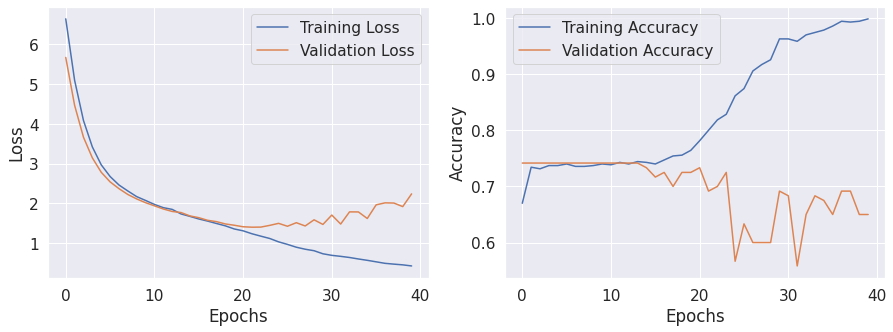

In [60]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist1.history["loss"], label = "Training Loss")
plt.plot( hist1.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist1.history["accuracy"], label = "Training Accuracy")
plt.plot( hist1.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [61]:
model_vgg16.evaluate(x_test,y_test)

6/6 [==============================] - 3s 594ms/step - loss: 2.1078 - accuracy: 0.6167


[2.1077754497528076, 0.6166666746139526]

In [62]:
predictions = model_vgg16.predict(x_test, batch_size = 32)
pred1 = np.argmax(predictions, axis=1)
y_test1 = np.argmax(y_test, axis=1)

In [63]:
print(classification_report(y_test1, pred1))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       133
           1       0.27      0.28      0.27        47

    accuracy                           0.62       180
   macro avg       0.51      0.51      0.51       180
weighted avg       0.62      0.62      0.62       180



In [64]:
print(confusion_matrix(y_test1, pred1))

[[98 35]
 [34 13]]


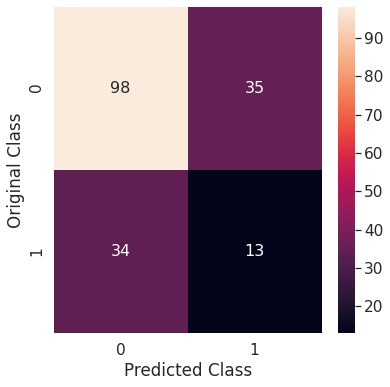

In [65]:
plt.figure(figsize=(6,6))
df_cm1 = pd.DataFrame(confusion_matrix(y_test1, pred1), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm1, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [66]:
y_pred_keras1 = model_vgg16.predict(x_test).ravel()

In [67]:
from sklearn.metrics import roc_curve

fpr_keras1, tpr_keras1, thresholds_keras1 = roc_curve(y_test1, pred1)

In [68]:
from sklearn.metrics import auc
auc_keras1 = auc(fpr_keras1, tpr_keras1)

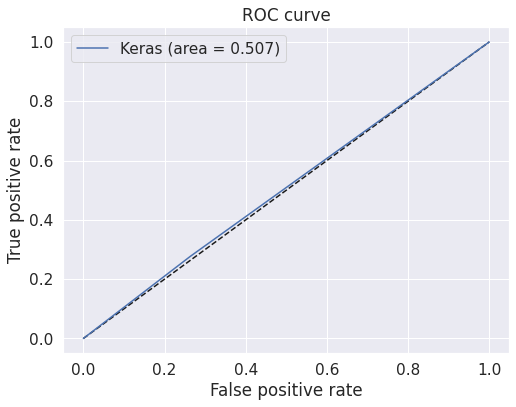

In [69]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras1, tpr_keras1, label='Keras (area = {:.3f})'.format(auc_keras1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [70]:
from keras.models import Sequential

model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
    
model_cnn.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
    
model_cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
    
model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dropout(0.5))

model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation='softmax'))

In [71]:
c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
model_cnn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model_cnn.fit(x_train,y_train,epochs=100,batch_size=16,validation_split=0.3)

NameError: name 'tf' is not defined

In [ ]:
print("Performance Report:")
y_pred=np.argmax(model_cnn.predict(x_test),axis=-1)
Y_test=to_categorical(y_test,5)
y_pred_prb=model_cnn.predict(x_test)
target=['0','1']
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, y_pred))
print('Precision score is :', metrics.precision_score(y_test, y_pred, average='weighted'))
print('Recall score is :',metrics.recall_score(y_test,y_pred, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, y_pred,average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, y_pred))
print('\t\tClassification Report:\n', metrics.classification_report(y_test,pred,target_names=target))